## Drifters and Cmems data Notebook

### Introduction
This notebook aims to analyze the velocity data from drifters within the tropical Atlantic Ocean. It involves visualizing drifter velocity data, interpolating CMEMS data onto drifter data, and comparing the velocities between drifters and CMEMS.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Data Product: Global Drifter Program Current of NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 230
  - link : https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/drifter_6hour_qc.html
  - Periode : period : 01-01-2019 to 31-12-2023

- CMEMS Data:
  - Source: Copernicus Marine, Satellite L4, Temporal resolution: Every 24 hours, Spatial resolution: 0.25°*0.25°
  - Data Product: SEALEVEL_GLO_PHY_L4_MY_008_047
  - link :  https://doi.org/10.48670/moi-00148
  - download data : ahttps://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/download
  - Periode : period : 01-01-2019 to 31-12-2023
  - DUACS is the operationnal multimission production system of altimeter data developed by CNES/CLS. It features multimission products based on all altimetry satellites from GEOSAT to Jason-3 for a total of 100 years of cumulated data.

### Tasks

#### 1. Visualization of Drifter Velocity Data
- Plot the Eastward (ve) and Northward (vn) velocity as a function of time for a selected drifter.

#### 2. Interpolation of CMEMS Data on Drifter Data
- Interpolate CMEMS data onto the time series of the selected drifter data.

#### 3. Comparison between Drifter Velocities and Interpolated CMEMS Velocities
- Visualize the correlation and regression between drifter velocities (ve, vn) and interpolated CMEMS between the two datasets.
- Plot time series of both drifter velocities and interpolated CMEMS velocities.

## Import Library


In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation
from scipy.stats import linregress
from scipy.stats import pearsonr

## Read Drifter Data


In [2]:
fn='./drifter_6hour_qc_82c1_ec1c_ea57_U1721837077629.nc';
ds=xr.open_dataset(fn);

## Extract Coordinates and Variables


In [3]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data


In [4]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr
}

df = pd.DataFrame(data)

## Space evolution of Eastward (ve) and Northward (vn) Velocity 

## Case of ve

The drifter is moving mainly southward.


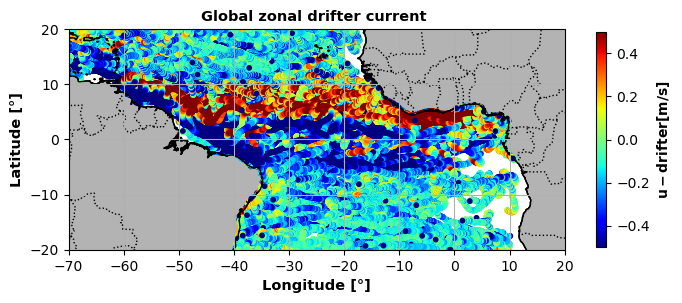

In [5]:
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
sc = ax.scatter(
    ds.longitude.values,
    ds.latitude.values,
    10,
    c=ds.ve.values,
    vmin=-0.5,
    vmax=0.5,
    transform=ccrs.PlateCarree(),
    cmap='jet')

ax.coastlines(resolution='10m', color='black')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='0.7', edgecolor='k')

# Example of drifter trajectory data (latitude, longitude)
longitude = df['longitude']
latitude = df['latitude']

# Calculating position changes
delta_lat = np.diff(latitude)
delta_lon = np.diff(longitude)

# Determining the general direction of movement
if np.abs(delta_lat.sum()) > np.abs(delta_lon.sum()):
    if delta_lat.sum() > 0:
        direction = "northward"
    else:
        direction = "southward"
else:
    if delta_lon.sum() > 0:
        direction = "eastward"
    else:
        direction = "westward"

print(f"The drifter is moving mainly {direction}.")

# Specify axes limits and ticks
plt.xlim(-70, 20)  # Longitude axis from 70W to 20E
plt.ylim(-20, 20)  # Latitude axis from 20S to 20N
plt.xticks(np.arange(-70, 30, 10))  # Longitude ticks every 10 degrees
plt.yticks(np.arange(-20, 30, 10))  # Latitude ticks every 10 degrees

# Specify colorbar limits based on actual Eastward velocity values
plt.colorbar(sc, orientation='vertical', shrink=0.7,label=r'$\mathbf{u-drifter [m/s]}$')

# Title and axes labels
ax.set_title('Global zonal drifter current ', fontsize=10.5, fontweight='bold')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.savefig("fig14 mode.png")
plt.show()

## Case of vn

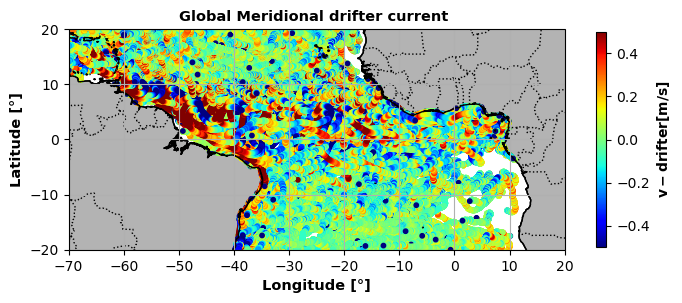

In [6]:
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
sc = ax.scatter(
    ds.longitude.values,
    ds.latitude.values,
    10,
    c=ds.vn.values,
    vmin=-0.5,
    vmax=0.5,
    transform=ccrs.PlateCarree(),
    cmap='jet')

ax.coastlines(resolution='10m', color='black')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='0.7', edgecolor='k')

# Specify axes limits and ticks
plt.xlim(-70, 20)  # Longitude axis from 70W to 20E
plt.ylim(-20, 20)  # Latitude axis from 20S to 20N
plt.xticks(np.arange(-70, 30, 10))  # Longitude ticks every 10 degrees
plt.yticks(np.arange(-20, 30, 10))  # Latitude ticks every 10 degrees

# Specify colorbar limits based on actual Eastward velocity values
plt.colorbar(sc, orientation='vertical', shrink=0.7,label=r'$\mathbf{v-drifter [m/s]}$')

# Title and axes labels
ax.set_title('Global Meridional drifter current ', fontsize=10.5, fontweight='bold')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.savefig("fig15 mode.png")
plt.show()

## Now let's interpolate the CMEMS data onto the grid of the drifter data.

### Case of Geostrophic Velocity Anomalies: Zonal Component (ugosa) 


- In this step, we interpolate the ugosa variable from the CMEMS data to the ve variable of the selected drifter.

- We utilize the linear interpolation method for this process. The interpolation is performed based on the variables of longitude, latitude, and important timestamps.

- This allows us to make comparisons and identify differences between drifter variables and CMEMS variables obtained through interpolations.

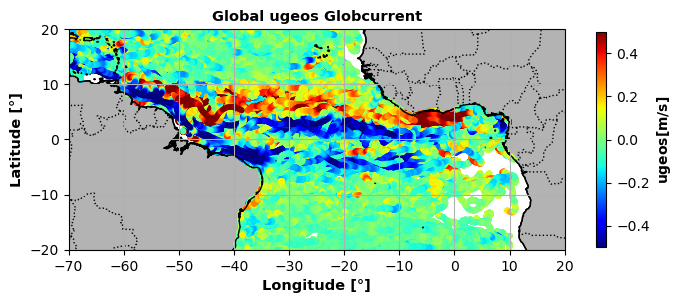

In [7]:
# Loading drifting buoy data from the DataFrame
df_bouees = df
 
# Loading satellite data from the netCDF file
ds_satellitaires = xr.open_dataset('ugos.nc')   

# Extracting current data from buoys
bouees_courant_u = df_bouees['ve']

# Extracting satellite current data for the same spatial and temporal positions as the buoys.
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_1 = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['ugos'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_1.append(courant)
    
# Plot the interpolated data
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
sc = ax.scatter(
    ds.longitude.values,
    ds.latitude.values,
    10,
    c= satellitaires_courant_1,
    vmin=-0.5,
    vmax=0.5,
    transform=ccrs.PlateCarree(),
    cmap='jet')

ax.coastlines(resolution='10m', color='black')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='0.7', edgecolor='k')

# Specify axes limits and ticks
plt.xlim(-70, 20)  # Longitude axis from 70W to 20E
plt.ylim(-20, 20)  # Latitude axis from 20S to 20N
plt.xticks(np.arange(-70, 30, 10))  # Longitude ticks every 10 degrees
plt.yticks(np.arange(-20, 30, 10))  # Latitude ticks every 10 degrees

# Specify colorbar limits based on actual Eastward velocity values
plt.colorbar(sc, orientation='vertical', shrink=0.7,label=r'$\mathbf{ugeos [m/s]}$')

# Title and axes labels
ax.set_title('Global ugeos Globcurrent', fontsize=10.5, fontweight='bold')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.savefig("fig16 mode.png")
plt.show()

### Case of Geostrophic Velocity Anomalies: Meridional Component (vgosa) 

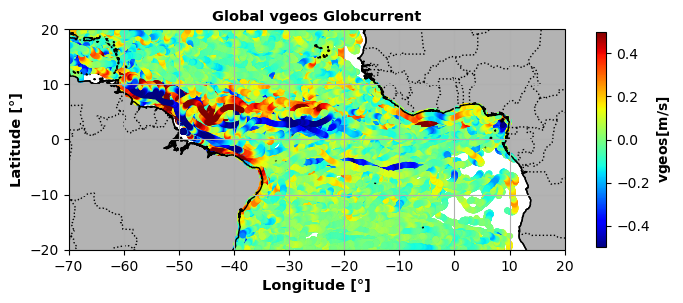

In [8]:
# Loading drifting buoy data from the DataFrame
df_bouees = df
 
# Loading satellite data from the netCDF file
ds_satellitaires = xr.open_dataset('vgos.nc')   

# Extracting current data from buoys
bouees_courant_v = df_bouees['vn']

# Extracting satellite current data for the same spatial and temporal positions as the buoys.
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_2 = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['vgos'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_2.append(courant)
    
# Plot the interpolated data
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
sc = ax.scatter(
    ds.longitude.values,
    ds.latitude.values,
    10,
    c= satellitaires_courant_2,
    vmin=-0.5,
    vmax=0.5,
    transform=ccrs.PlateCarree(),
    cmap='jet')

ax.coastlines(resolution='10m', color='black')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='0.7', edgecolor='k')

# Specify axes limits and ticks
plt.xlim(-70, 20)  # Longitude axis from 70W to 20E
plt.ylim(-20, 20)  # Latitude axis from 20S to 20N
plt.xticks(np.arange(-70, 30, 10))  # Longitude ticks every 10 degrees
plt.yticks(np.arange(-20, 30, 10))  # Latitude ticks every 10 degrees

# Specify colorbar limits based on actual Eastward velocity values
plt.colorbar(sc, orientation='vertical', shrink=0.7,label=r'$\mathbf{vgeos [m/s]}$')

# Title and axes labels
ax.set_title('Global vgeos Globcurrent', fontsize=10.5, fontweight='bold')
plt.xlabel('Longitude [°]', fontsize=10.5, fontweight='bold')
plt.ylabel('Latitude [°]', fontsize=10.5, fontweight='bold')
plt.grid(True)
plt.savefig("fig17 mode.png")
plt.show()

## Now Let's Compare Drifter Speeds and  CMEMS Speeds

## Comparison between ve and ugosa


## Using Regression and Correlation

Corrélation de Pearson: 0.6877452983362321
Valeur de p (p-value): 0.0


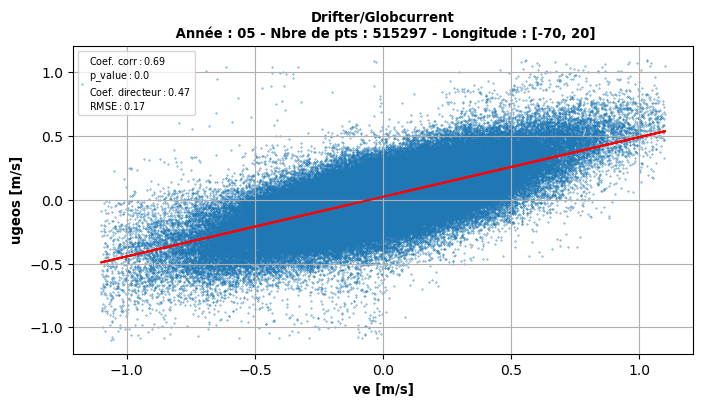

In [9]:
# Convert lists into NumPy arrays
bouees_courant_u = np.array(bouees_courant_u)
satellitaires_courant_1 = np.array(satellitaires_courant_1)

x = bouees_courant_u
y = satellitaires_courant_1
# Filter values strictly greater than 1.1 and less than -1.1 in both x and y.

valid_indices = np.logical_and(np.logical_and(x <= 1.1, x >= -1.1), np.logical_and(y <= 1.1, y >= -1.1))
x_filtered = x[valid_indices]
y_filtered = y[valid_indices]

# Remove the rows where y contains NaN and keep the corresponding values in x.
valid_indice = ~np.isnan(y_filtered)
x_clean = x_filtered[valid_indice]
y_clean = y_filtered[valid_indice]

# Calculation of Pearson correlation
correlation, p_value = pearsonr(x_clean, y_clean)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( x_clean,y_clean)

# Calcul de la régression linéaire
coefficients = np.polyfit(x_clean, y_clean, 1)
p = np.poly1d(coefficients) # p = 0.47

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((x_clean - y_clean)**2)) # r = 0.17

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(x_clean,y_clean,s=0.1)
plt.plot(x_clean, slope*x_clean + intercept, color='red', label='Linear Regression')
plt.xlabel('ve [m/s]', fontsize=9.5, fontweight='bold')
plt.ylabel('ugeos [m/s]', fontsize=9.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.69$' + '\n'
    r'$\text{p_value} : 0.0$' + '\n'
    r'$\text{Coef. directeur} : 0.47$' + '\n'
    r'$\text{RMSE} : 0.17$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Année : 05 - Nbre de pts : 515297 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=9.5, fontweight='bold')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig18 mode.png")
plt.show()

## Using Time Series

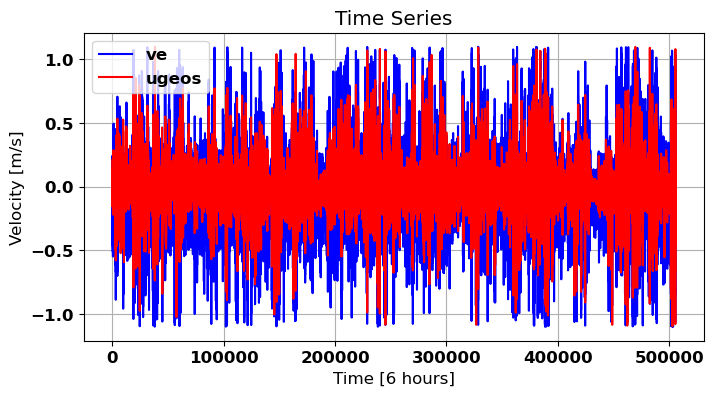

In [10]:
 # Plot time series
plt.figure(figsize=(8, 4))
plt.plot(x_clean, color='Blue',label='ve')
plt.plot(y_clean, color='RED', label='ugeos')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Time Series')
plt.xlabel('Time [6 hours]')
plt.ylabel('Velocity [m/s]')
plt.grid(True)
plt.legend()
plt.savefig("fig19 mode.png")
plt.show()

## Comparison between vn and vgosa

## Using Regression and Correlation

Corrélation de Pearson: 0.43871637402596075
Valeur de p (p-value): 0.0


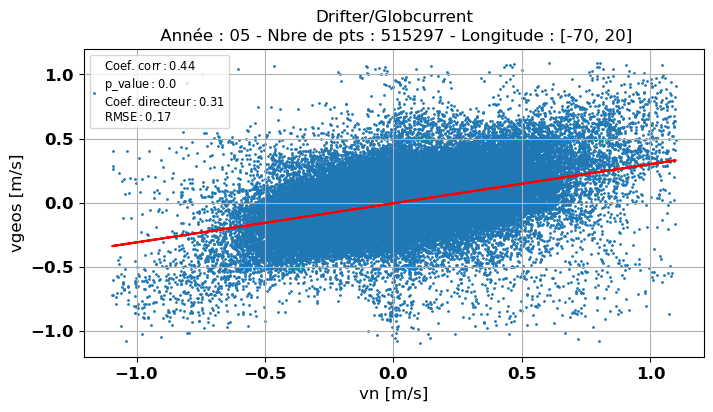

In [11]:
# Convert lists into NumPy arrays
bouees_courant_v = np.array(bouees_courant_v)
satellitaires_courant_2 = np.array(satellitaires_courant_2)

x = bouees_courant_v
y = satellitaires_courant_2
# Filter values strictly greater than 1.1 and less than -1.1 in both x and y.

valid_indices = np.logical_and(np.logical_and(x <= 1.1, x >= -1.1), np.logical_and(y <= 1.1, y >= -1.1))
x_filtered = x[valid_indices]
y_filtered = y[valid_indices]

# Remove the rows where y contains NaN and keep the corresponding values in x.
valid_indice = ~np.isnan(y_filtered)
x_clean_2 = x_filtered[valid_indice]
y_clean_2 = y_filtered[valid_indice]

# Calculation of Pearson correlation
correlation, p_value = pearsonr(x_clean_2, y_clean_2)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( x_clean_2,y_clean_2)

# Calcul de la régression linéaire
coefficients = np.polyfit(x_clean_2, y_clean_2, 1)
p = np.poly1d(coefficients) # p = 0.31

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(np.mean((x_clean - y_clean)**2)) # r = 0.17

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(x_clean_2,y_clean_2, s=1)
plt.plot(x_clean_2, slope*x_clean_2 + intercept, color='red', label='Linear Regression')
plt.xlabel('vn [m/s]')
plt.ylabel('vgeos [m/s]')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.44$' + '\n'
    r'$\text{p_value} : 0.0$' + '\n'
    r'$\text{Coef. directeur} : 0.31$' + '\n'
    r'$\text{RMSE} : 0.17$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='x-small', title_fontsize='x-small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Année : 05 - Nbre de pts : 515297 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=12)
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig20 mode.png")
plt.show()

## Using Time Series

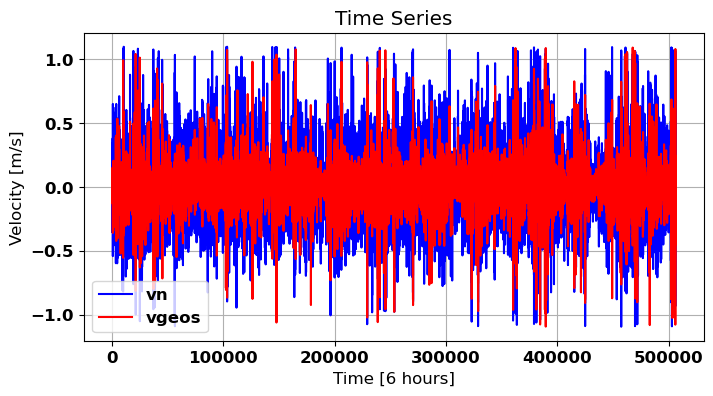

In [12]:
 # Plot time series
plt.figure(figsize=(8, 4))
plt.plot(x_clean_2, color='Blue',label='vn')
plt.plot(y_clean_2, color='RED', label='vgeos')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Time Series')
plt.xlabel('Time [6 hours]')
plt.ylabel('Velocity [m/s]')
plt.grid(True)
plt.legend()
plt.savefig("fig21 mode.png")
plt.show()

## Summarize

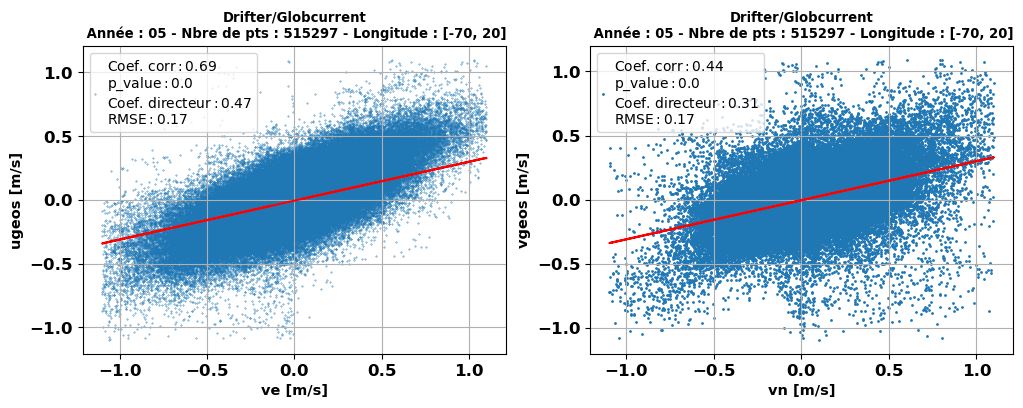

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Premier sous-graphique

plt.scatter(x_clean,y_clean,s=0.1)
plt.plot(x_clean, slope*x_clean + intercept, color='red', label='Linear Regression')
plt.xlabel('ve [m/s]', fontsize=10.5, fontweight='bold')
plt.ylabel('ugeos [m/s]', fontsize=10.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.69$' + '\n'
    r'$\text{p_value} : 0.0$' + '\n'
    r'$\text{Coef. directeur} : 0.47$' + '\n'
    r'$\text{RMSE} : 0.17$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='small', title_fontsize='small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Année : 05 - Nbre de pts : 515297 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=9.5, fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2)  # Premier sous-graphique

plt.scatter(x_clean_2,y_clean_2, s=1)
plt.plot(x_clean_2, slope*x_clean_2 + intercept, color='red', label='Linear Regression')
plt.xlabel('vn [m/s]', fontsize=10.5, fontweight='bold')
plt.ylabel('vgeos [m/s]', fontsize=10.5, fontweight='bold')

# Légende
legend_text = (
    r'$\text{Coef. corr} : 0.44$' + '\n'
    r'$\text{p_value} : 0.0$' + '\n'
    r'$\text{Coef. directeur} : 0.31$' + '\n'
    r'$\text{RMSE} : 0.17$'
)

# Affichage de la légende
plt.legend([legend_text], title='', fontsize='small', title_fontsize='small', handlelength=0, loc="upper left")

# Titre
title_text = 'Drifter/Globcurrent\n Année : 05 - Nbre de pts : 515297 - Longitude : [-70, 20]'
plt.title(title_text, fontsize=9.5, fontweight='bold')
plt.grid(True)
plt.savefig("fig55 mode.png")

## Conclusion
 - Moderate relationship between the variables ugeos (CMEMS Current) and u-drifter (Drifter Current).
 - Moderate relationship  between vgeos (CMEMS Current) and v-drifter (Drifter Current).
 - Equal measure between the zonal and meridional components of geostrophic currents.
 - Altimetric current measurements are better and can be improved by considering certain components, notably Ekman and inertial components.